In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0

In [2]:
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(train_labels.head)

<bound method NDFrame.head of                                               id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 columns]>


In [3]:
print(train_labels.shape)

(220025, 2)


# Brief description of the problem and data 


We have set of images which we want to train on to do binary classification with multi layer of nodes(filters) to detarmine the cancer detection for the test images. The data has size of 220025 rows with 2 columns of image id & cancer detection label. The data has more of non-cancer images than cancer images close to 3:2 ratio.

#  Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data  

We will be removing all the rows where the labels aren't either 0 or 1. We would be taking 25k rows of each label to make the training balanced without either over sampling or under sampling.

We will start with using basic model like CNN with few layers & start changing the activation function & increasing to see the prediction. We will also use model with few layers & gradually with more layers validate the prediction. Later, we will be using pretrained model like EfficientNet & finetuning it to our dataset.

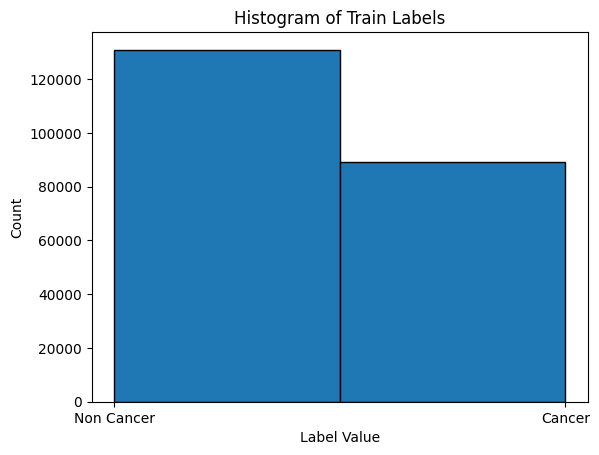

In [4]:
plt.hist(train_labels['label'], bins=2, edgecolor='black')  # bins=2 for binary data
plt.title('Histogram of Train Labels')
plt.xlabel('Label Value')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non Cancer', 'Cancer'])
plt.show()

In [5]:
# removing the rows who label value is non 0 or 1
train_labels = train_labels[train_labels['label'].isin([0, 1])]

In [6]:
non_cancer_data = train_labels[train_labels['label'] == 0]
cancer_data = train_labels[train_labels['label'] == 1]

non_cancer_samples = non_cancer_data.sample(n=25000, random_state=42, replace=False)
cancer_samples = cancer_data.sample(n=25000, random_state=42, replace=False)

train_data = pd.concat([non_cancer_samples, cancer_samples])

train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'
def load_image_from_id(image_id, image_dir=train_dir):
    image_path = image_dir + image_id + '.tif'
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [8]:
images = np.array([load_image_from_id(i) for i in train_data['id']])
y = train_data['label'].values

# DModel Architecture

We will start with a basic CNN model with 2 layers of filters of 20 & 60 respectively using relu activation function & maxpooling after each layer & finally densing it out to a single array with relu & finally densing to a single value & applying sigmoid to determine cancer prediction.

# cnn model1

In [9]:

cnn_model1 = keras.Sequential([
    layers.Input(shape=(96,96,3)),
    layers.Rescaling(1./255), # normalizing the values from 0 to 1
    layers.Cropping2D(cropping=32),
    layers.Conv2D(20, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(60, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    
    # Output layer
    layers.Dense(1, activation='sigmoid')    
])

cnn_model1.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='binary_crossentropy',
    metrics=['accuracy', 'auc']
)
cnn_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d (Cropping2D)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 20)          │             560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 20)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 60)          │          10,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 60)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3840)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         245,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 257,309 (1005.11 KB)

 Trainable params: 257,309 (1005.11 KB)

 Non-trainable params: 0 (0.00 B)

we would be doing 1:4 split of test vs train data & would run for 50 epochs & have a stop function of 5(when the loss function hasn't improved for the 5 runs).

In [10]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_model1 = cnn_model1.fit(images, y, validation_split=0.2, epochs=50, callbacks=[es])

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.6464 - auc: 0.7030 - loss: 0.6287 - val_accuracy: 0.7581 - val_auc: 0.8267 - val_loss: 0.5166
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7513 - auc: 0.8147 - loss: 0.5311 - val_accuracy: 0.7598 - val_auc: 0.8335 - val_loss: 0.5072
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7660 - auc: 0.8316 - loss: 0.5088 - val_accuracy: 0.7626 - val_auc: 0.8374 - val_loss: 0.5023
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7671 - auc: 0.8329 - loss: 0.5064 - val_accuracy: 0.7588 - val_auc: 0.8403 - val_loss: 0.5012
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7705 - auc: 0.8357 - loss: 0.5026 - val_accuracy: 0.7675 - val_auc: 0.8420 - val_loss: 0.4936
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7706 - auc: 0.8367 - loss: 0.5003 - val_accuracy: 0.7656 - val_auc: 0.8452 - val_loss: 0.4928
Epoch 7/50
1250/1250 ━━━━━━

Now we are adding on one more layer in between with 40 filters & making the rest of the architecture of the model to be same as above model.

# cnn model2

In [11]:
# Adding one more layer in between with 40 nodes
cnn_model2 = keras.Sequential([
    layers.Input(shape=(96,96,3)),
    layers.Rescaling(1./255), # normalizing the values from 0 to 1
    layers.Cropping2D(cropping=32),
    layers.Conv2D(20, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(40, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(60, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Prevent overfitting
    
    # Output layer
    layers.Dense(1, activation='sigmoid')    
])

cnn_model2.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='binary_crossentropy',
    metrics=['accuracy', 'auc']
)
cnn_model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d_1 (Cropping2D)            │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 20)          │             560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 20)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 40)          │           7,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 40)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 60)            │          21,660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 60)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          61,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,029 (355.58 KB)

 Trainable params: 91,029 (355.58 KB)

 Non-trainable params: 0 (0.00 B)

We will still be having the same above hyper parameters, to test the impact from additional layers

In [12]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_model2 = cnn_model2.fit(images, y, validation_split=0.2, epochs=50, callbacks=[es])

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6274 - auc: 0.6760 - loss: 0.6418 - val_accuracy: 0.7561 - val_auc: 0.8272 - val_loss: 0.5178
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7569 - auc: 0.8199 - loss: 0.5230 - val_accuracy: 0.7615 - val_auc: 0.8310 - val_loss: 0.5096
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7636 - auc: 0.8277 - loss: 0.5125 - val_accuracy: 0.7625 - val_auc: 0.8330 - val_loss: 0.5063
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7632 - auc: 0.8260 - loss: 0.5150 - val_accuracy: 0.7624 - val_auc: 0.8364 - val_loss: 0.5019
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7660 - auc: 0.8317 - loss: 0.5076 - val_accuracy: 0.7558 - val_auc: 0.8382 - val_loss: 0.5088
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7679 - auc: 0.8357 - loss: 0.5026 - val_accuracy: 0.7647 - val_auc: 0.8399 - val_loss: 0.4972
Epoch 7/50
1250/1250 ━━━━━━

Now we would like to use a pretrained advanced models like Efficient net on image training. We will use the parameters of this model & try to fit for our images of 64x64 pixels. This is 4million+ parameter model, I assume this might overfit our smaller dataset but we would still try & verify.

# EfficientNet model1

In [13]:
from tensorflow.keras.applications import EfficientNetB0

# Local path to the uploaded weights
weights_path = '/kaggle/input/efficient_net/keras/default/1/efficientnetb0_notop.h5'
base_model = EfficientNetB0(weights=weights_path, include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False  # freezes during initial training.

effnet_model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
effnet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 3, 3, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,131,620 (15.76 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Using Adam optimizer which is suitable for efficient net models, we are using a learning rate of 0.0001 slightly higher than the above cnn model but with a lower patience & epochs.

In [27]:
effnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'auc']
)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model1 = effnet_model.fit(images, y, validation_split=0.20, epochs=50, callbacks=[es])

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - accuracy: 0.8923 - auc: 0.9589 - loss: 0.2600 - val_accuracy: 0.8819 - val_auc: 0.9488 - val_loss: 0.2937
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8911 - auc: 0.9593 - loss: 0.2586 - val_accuracy: 0.8801 - val_auc: 0.9490 - val_loss: 0.2953
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8928 - auc: 0.9594 - loss: 0.2597 - val_accuracy: 0.8819 - val_auc: 0.9494 - val_loss: 0.2925
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8906 - auc: 0.9588 - loss: 0.2603 - val_accuracy: 0.8817 - val_auc: 0.9496 - val_loss: 0.2913
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8958 - auc: 0.9613 - loss: 0.2524 - val_accuracy: 0.8819 - val_auc: 0.9498 - val_loss: 0.2920
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8949 - auc: 0.9610 - loss: 0.2542 - val_accuracy: 0.8828 - val_auc: 0.9496 - val_loss: 0.2922
Epoch 7/50
1250/

Here we are going to build a same efficient net model but with tuning hyper parameters with higher learning rate of 0.001, different split of data between training & testing. Additionally, we are decreasing epochs as well.

# EfficientNet model2 (hyper parameters tuning from the above model)

In [19]:
effnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'auc']
)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model2 = effnet_model.fit(images, y, validation_split=0.20, epochs=50, callbacks=[es])

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - accuracy: 0.8788 - auc: 0.9505 - loss: 0.2833 - val_accuracy: 0.8765 - val_auc: 0.9469 - val_loss: 0.3051
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8772 - auc: 0.9501 - loss: 0.2859 - val_accuracy: 0.8744 - val_auc: 0.9454 - val_loss: 0.3062
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - accuracy: 0.8794 - auc: 0.9509 - loss: 0.2845 - val_accuracy: 0.8777 - val_auc: 0.9460 - val_loss: 0.3028
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.8790 - auc: 0.9520 - loss: 0.2800 - val_accuracy: 0.8775 - val_auc: 0.9470 - val_loss: 0.2977
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8815 - auc: 0.9535 - loss: 0.2749 - val_accuracy: 0.8767 - val_auc: 0.9476 - val_loss: 0.2973
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8815 - auc: 0.9519 - loss: 0.2804 - val_accuracy: 0.8783 - val_auc: 0.9477 - val_loss: 0.2981
Epoch 7/50
1250/

# Result & analysis
The initial CNN model with 2 layers has gave us val_accuracy: 0.8015 - val_auc: 0.8821 - val_loss: 0.4299
The 2nd model with an additional layer has gave us val_accuracy: 0.7983 - val_auc: 0.8761 - val_loss: 0.4403 (with same hyper parameters as above)

Then we have used a better model efficient net but we think it might overfit with more parameters & small dataset.
This model has val_accuracy: 0.8836 - val_auc: 0.9506 - val_loss: 0.2931. this is far better than the above both models.

Then we have increased the learning rate to see how it performs & have a different of data.
This one gave val_accuracy: 0.8788 - val_auc: 0.9465 - val_loss: 0.3049







# Evaluation


In [20]:
def plot_validation_accuracy_condensed(model, model_name=None):
    
    val_accuracy = model.history['val_accuracy']

    epochs = range(1, len(val_accuracy) + 1)

    plt.figure(figsize=(7, 4)) # Slightly smaller figure
    plt.plot(epochs, val_accuracy, marker='.', linestyle='-', label='Val Accuracy') # Smaller marker
    plt.title(f'{model_name} - Val Accuracy' if model_name else 'Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    if len(epochs) <= 15: plt.xticks(epochs)
    else: plt.locator_params(axis='x', integer=True)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Grid on y-axis only, lighter
    plt.tight_layout() # Adjust layout
    plt.show()


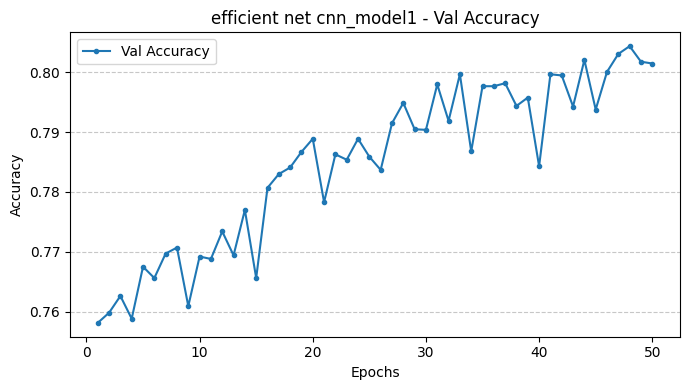

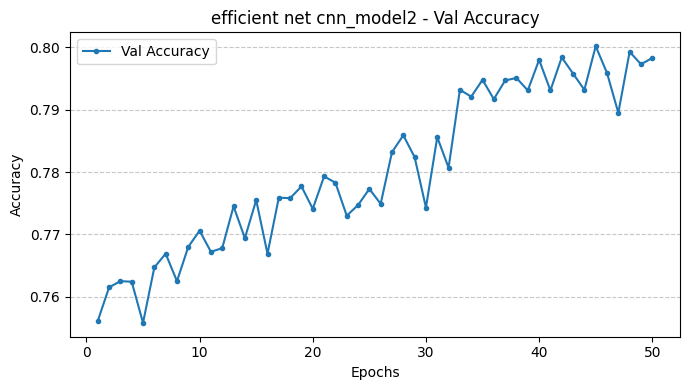

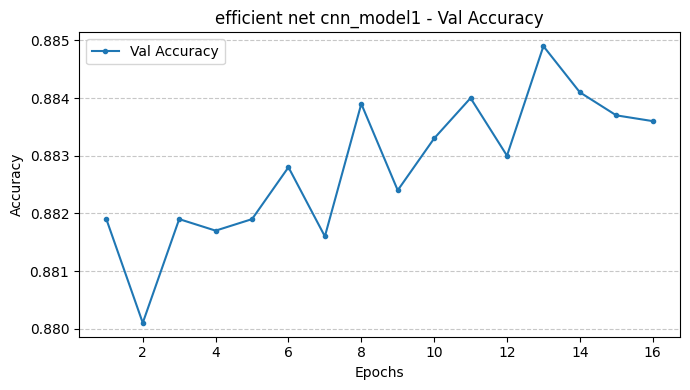

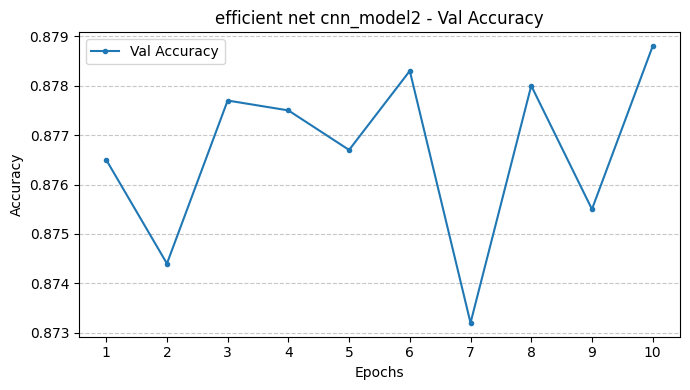

In [28]:
plot_validation_accuracy_condensed(cnn_model1, "efficient net cnn_model1")
plot_validation_accuracy_condensed(cnn_model2, "efficient net cnn_model2")
plot_validation_accuracy_condensed(model1, "efficient net cnn_model1")
plot_validation_accuracy_condensed(model2, "efficient net cnn_model2")

# Conclusion

The 2nd CNN model has an additional layer of filters but it has less parameters & it's less accurate than the 1st model. The efficient net model is advanced & it's pretrained & we are finetuning it's existing parameters. So this has the better accuracy & performance. Later, we have tuned the hyper parameters by increasing the learning rate, it has decreased the accuracy.
The key learning is to use a pretrained model with it's existing weights & finetune it to our dataset to have the best model & accuracy. We need to have a balanced learning rate to have better accuracy. 